## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, MultiLineString, Point, LineString

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
save = True
save_space = True

## Required data

### Required data - Area of Interest

['Aguascalientes' 'Jesús María' 'San Francisco de los Romo']


<Axes: >

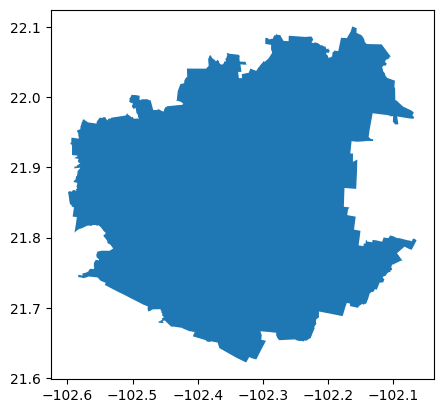

In [3]:
city = 'Aguascalientes'

# Source Data
schema = 'metropolis'
folder = 'metro_gdf'

# Downloads hexagons within 'city'
query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.NOMGEO.unique())

mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()
aoi = aoi[['city','geometry']]

# Saves space in disk if instructed
if save_space:
    del mun_gdf

#Show
aoi.plot()

### Required data - nodes and edges from notebook prox_loading_osmnx 1 [Script 07-download_osmnx]

In [4]:
nodes = gpd.read_file("../../data/external/temporal_fromjupyter/nodes.gpkg")

# Check if there is any list in any column (Shouldn't be)
for col in nodes.columns:
    if any(isinstance(val, list) for val in nodes[col]):
        #nodes[col] = nodes[col].astype('string')
        #---------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Column: {col} in nodes gdf, has a list in it.")
        #---------------------------------------------------------------------------------------------------------------------------------------------
        
#Show
print(nodes.shape)
print(nodes.dtypes)
nodes.head(2)

(57478, 5)
osmid              int64
x                float64
y                float64
street_count       int64
geometry        geometry
dtype: object


,osmid,x,y,street_count,geometry
0,301189389,-102.342212,21.848544,4,POINT (-102.34221 21.84854)
1,301189406,-102.350222,21.850815,3,POINT (-102.35022 21.85082)


In [5]:
edges = gpd.read_file("../../data/external/temporal_fromjupyter/edges.gpkg")

# Check if there is any list in any column (Shouldn't be)
for col in edges.columns:
    if any(isinstance(val, list) for val in edges[col]):
        #edges[col] = edges[col].astype('string')
        #---------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Column: {col} in nodes gdf, has a list in it.")
        #---------------------------------------------------------------------------------------------------------------------------------------------
        
#Show
print(edges.shape)
print(edges.dtypes)
edges.head(2)

(135456, 18)
osmid         object
v              int64
u              int64
key            int64
oneway          bool
lanes         object
name          object
highway       object
maxspeed      object
length       float64
bridge        object
ref           object
junction      object
tunnel        object
access        object
width         object
service       object
geometry    geometry
dtype: object


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,713153965,1408187972,301189389,0,False,NaN,Prolongación Constitución,residential,NaN,13.812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-102.34221 21.84854, -102.34219 21..."
1,715583649,9370947312,301189389,0,True,2,Avenida Siglo XXI,trunk,NaN,412.235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-102.34221 21.84854, -102.34600 21..."


### Required data - Points of interest

In [6]:
# Get pois with distance to nearest node calculated
pois_distance_node = gpd.read_file("../../data/external/temporal_fromjupyter/pois_distance_node.gpkg")

#Show
print(pois_distance_node.shape)
print(pois_distance_node.dtypes)
pois_distance_node.head(2)

(20593, 4)
code               object
osmid               int64
distance_node     float64
geometry         geometry
dtype: object


,code,osmid,distance_node,geometry
0,611111,1453747584,8.434524,POINT (-102.32776 21.94211)
1,611111,3324147003,19.788102,POINT (-102.26791 21.92303)


## Step 2: Function definitions

### Function definitions - graph_from_hippo

In [8]:
def graph_from_nodes_and_edges(gdf, nodes, edges):
    # ------------------------------------------------------ CODE CHANGE NEEDED: INSTEAD OF QUERRING FROM DB FROM A POLY_WKT, OVERLAY IS USED.
    # Query edges intersecting area of interest
    edges_gdf = gpd.overlay(gdf,edges,keep_geom_type=False)

    # Delete useless columns resulting from overlay
    edges_columns = [
        "osmid",
        "v",
        "u",
        "key",
        "oneway",
        "lanes",
        "name",
        "highway",
        "maxspeed",
        "length",
        "geometry",
        "bridge",
        "ref",
        "junction",
        "tunnel",
        "access",
        "width",
        "service",
    ]

    edges_gdf = edges_gdf[edges_columns]

    # Find nodes belonging to those querried edges
    nodes_id = list(edges_gdf.v.unique())
    u = list(edges_gdf.u.unique())
    nodes_id.extend(u)
    myset = set(nodes_id)
    nodes_id = list(myset)

    # ------------------------------------------------------ CODE CHANGE NEEDED: INSTEAD OF QUERRING FROM DB WHERE osmid IN {str(tuple(nodes_id))}, isin(nodes_id list) IS USED.
    # Query those nodes
    idx = nodes['osmid'].isin(nodes_id)
    nodes_gdf = nodes.loc[idx]

    # Drop duplicates
    edges_gdf.drop_duplicates(inplace=True) 
    nodes_gdf.drop_duplicates(inplace=True)

    # Format
    nodes_gdf = nodes_gdf.set_index('osmid')
    edges_gdf = edges_gdf.set_index(["u", "v", "key"])

    nodes_gdf = nodes_gdf.set_crs("EPSG:4326")
    edges_gdf = edges_gdf.set_crs("EPSG:4326")

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Querried and formated nodes and edges within area of interest.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    # Making sure all nodes belonging to edges_gdf are present in nodes_gdf
    nodes_tmp = nodes_gdf.reset_index().copy()
    edges_tmp = edges_gdf.reset_index().copy()

    # Current nodes in nodes_gdf
    nodes_dict = nodes_tmp.to_dict()

    # U nodes
    # U nodes that are in edges_tmp but not in nodes_tmp
    from_osmid = list(set(edges_tmp['u'].to_list()).difference(set(nodes_tmp.osmid.to_list())))

    # Iterating over each missing U node and adding its data to nodes_dict
    for i in from_osmid:
        row = edges_tmp.loc[(edges_tmp.u==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]

        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = first_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = first_coord[1]
        nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(first_coord)

    # V nodes
    # V nodes that are in edges_tmp but not in nodes_dict                                                      #Duda para Edgar: ¿Por qué en U nodes revisamos nodes_tmp pero en V nodes revisamos nodes_dict?
    to_osmid = list(set(edges_tmp['v'].to_list()).difference(set(list(nodes_dict['osmid'].values()))))

    # Iterating over each missing V node and adding its data to nodes_dict
    for i in to_osmid:
        row = edges_tmp.loc[(edges_tmp.v==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]

        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = last_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = last_coord[1]
        nodes_dict['street_count'][len(nodes_dict['street_count'])] = np.nan
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(last_coord)

    # Rewriting nodes_gdf from updated nodes_dict
    nodes_tmp = pd.DataFrame.from_dict(nodes_dict)
    nodes_tmp = gpd.GeoDataFrame(nodes_tmp, crs="EPSG:4326", geometry='geometry')
    nodes_gdf = nodes_tmp.copy()
    nodes_gdf.set_index('osmid',inplace=True)    

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Missing nodes from edges added to nodes gdf.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Created graph.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    return G, nodes_gdf, edges_gdf

In [9]:
# Get graph, nodes and edges
G, nodes_gdf, edges_gdf = graph_from_nodes_and_edges(aoi, nodes, edges)
# Format
edges_gdf['length'].fillna(edges_gdf['length'].mean(),inplace=True)

/tmp/ipykernel_13782/2659713794.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_gdf.drop_duplicates(inplace=True)


Querried and formated nodes and edges within area of interest.
Missing nodes from edges added to nodes gdf.
Created graph.


In [10]:
#Show
print(nodes_gdf.shape)
print(nodes_gdf.dtypes)
nodes_gdf.head(2)

(52081, 4)
x                float64
y                float64
street_count       int64
geometry        geometry
dtype: object


,x,y,street_count,geometry
osmid,,,,
301189389,-102.342212,21.848544,4,POINT (-102.34221 21.84854)
301189406,-102.350222,21.850815,3,POINT (-102.35022 21.85082)


In [11]:
#Show
print(edges_gdf.shape)
print(edges_gdf.dtypes)
edges_gdf.head(2)

(121337, 15)
osmid         object
oneway          bool
lanes         object
name          object
highway       object
maxspeed      object
length       float64
geometry    geometry
bridge        object
ref           object
junction      object
tunnel        object
access        object
width         object
service       object
dtype: object


osmid  oneway lanes                       name  \
u         v          key                                                       
301189389 1408187972 0    713153965   False   NaN  Prolongación Constitución   
          9370947312 0    715583649    True     2          Avenida Siglo XXI   

                              highway maxspeed   length  \
u         v          key                                  
301189389 1408187972 0    residential      NaN   13.812   
          9370947312 0          trunk      NaN  412.235   

                                                                   geometry  \
u         v          key                                                      
301189389 1408187972 0    LINESTRING (-102.34221 21.84854, -102.34219 21...   
          9370947312 0    LINESTRING (-102.34221 21.84854, -102.34600 21...   

                         bridge  ref junction tunnel access width service  
u         v          key                                                   
301189389 1408187972 0      NaN  NaN      NaN    NaN    NaN   NaN     NaN  
          9370947312 0      NaN  NaN      NaN    NaN    NaN   NaN     NaN

In [10]:
sources = """{ 
    #Preescolar
    'denue_preescolar':[611111, 611112],
    #Primaria
    'denue_primaria':[611121, 611122],
    #Secundaria
    'denue_secundaria':[611131, 611132],
    #Salud
    'clues_primer_nivel':[8610],
    #Guarderías
    'denue_guarderias':[624411, 624412],
    #Asistencia social
    'denue_dif':[931610],
    #Alimentos
    'denue_supermercado':[462111],'denue_abarrotes':[461110], 'denue_carnicerias': [461121, 461122, 461123],'sip_mercado':[4721],
    #Personal       
    'denue_peluqueria':[812110],
    #Farmacias       
    'denue_farmacias':[464111, 464112],
    #Hogar       
    'denue_ferreteria_tlapaleria':[467111],'denue_art_limpieza':[467115],
    #Complementarios
    'denue_ropa':[463211, 463212, 463213, 463215, 463216, 463218],'denue_calzado':[463310], 'denue_muebles':[466111, 466112, 466113, 466114],'denue_lavanderia':[812210],'denue_revistas_periodicos':[465313],'denue_pintura':[467113],
    #Social
    'denue_restaurante_insitu':[722511, 722512, 722513, 722514, 722519],'denue_restaurante_llevar':[722516, 722518, 722517],'denue_bares':[722412],'denue_cafe':[722515],
    #Actividad física       
    'sip_cancha':[9311],'sip_unidad_deportiva':[9311],'sip_espacio_publico':[9321],'denue_parque_natural':[712190],
    #Cultural       
    'denue_cines':[512130],'denue_museos':[712111, 712112]}"""

In [12]:
sources = { 
    #Preescolar
    'denue_preescolar':[611111, 611112]}

In [13]:
# ELEMENTS NEEDED OUTSIDE THE LOOP
# nodes_analysis is a nodes_gdf out of loop used in aup.calculate_distance_nearest_poi in each loop
nodes_analysis = nodes_gdf.reset_index().copy()
# nodes_sources is a nodes_gdf out of loop used to accumulate a final gdf with the minimal distance from each node to each source
nodes_sources = gpd.GeoDataFrame()
# Count
i = 0

# Loop that calculates distance from each node to each source (source by source)
for s in sources:
    
    # Locate pois data for current source
    source_gdf = gpd.GeoDataFrame()
    for cod in sources[s]:
        source_tmp = pois_distance_node[pois_distance_node['code']==f'{cod}']
        source_gdf = pd.concat([source_gdf,source_tmp])
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Loaded a total of {len(source_gdf)} points of interest of the source {s} for analisis.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Data for current amenity loop - df_temp: Each column will be a batch of procesed nodes.
    df_temp = nodes_gdf.copy()
    # Data for current amenity loop - nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance and finally to nodes_sources (outside loop)
    nodes_distance = nodes_gdf.copy()
    
    # In case there are no amenities of a certain type in the city
    if len(source_gdf) == 0:
        nodes_distance['dist_'+s] = 0
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"0 points of interest of the source {s} found.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------       
    
    # Elif, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)
    elif len(source_gdf) % 250:
        batch_size = len(source_gdf)/200
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(200*k):int(200*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated distance for a TOTAL of {len(nodes_distance)} nodes.")
        #------------------------------------------------------------------------------------------------------------------------------------------------- 

    # Else, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)   
    else:
        batch_size = len(source_gdf)/250
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
    
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated distance for a TOTAL of {len(nodes_distance)} nodes.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------    
    
    # Calculate time (Walking speed = 4km/hr)
    nodes_time = nodes_distance.copy()
    if len(source_gdf) == 0:
        nodes_time['time'] = np.nan
    else:
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
    
    #Format nodes_distance
    nodes_time['source'] = s
    nodes_time['city'] = city
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time','source','x','y','geometry','city']]
    
    #If it is the first round nodes_sources is created equal to nodes_distance (all nodes, one source)
    #If it is the second or more, the new nodes_distance is merged.
    #This way we obtain the final gdf of interest that will contain the minimum disstance to each type of amenity by column.
    if i == 0:
        nodes_sources = nodes_time.copy()
    else:
        nodes_sources = pd.concat([nodes_sources,nodes_time])
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Added time for source {s} to nodes_sources.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------        
    
    i += 1

Loaded a total of 303 points of interest of the source denue_preescolar for analisis.
Starting range k = 0 of 1 for source denue_preescolar.
Starting range k = 1 of 1 for source denue_preescolar.
Calculated distance for a TOTAL of 52013 nodes.
Added time for source denue_preescolar to nodes_sources.


In [14]:
nodes_sources

,osmid,time,source,x,y,geometry,city
0,301189389,6.400245,denue_preescolar,-102.342212,21.848544,POINT (-102.34221 21.84854),Aguascalientes
1,301189406,17.556360,denue_preescolar,-102.350222,21.850815,POINT (-102.35022 21.85082),Aguascalientes
2,301191695,6.655365,denue_preescolar,-102.342228,21.848392,POINT (-102.34223 21.84839),Aguascalientes
3,301191702,11.940270,denue_preescolar,-102.326375,21.843567,POINT (-102.32638 21.84357),Aguascalientes
4,395436249,22.370580,denue_preescolar,-102.331855,21.843707,POINT (-102.33186 21.84371),Aguascalientes
...,...,...,...,...,...,...,...
52008,11201041922,29.143890,denue_preescolar,-102.292966,21.814457,POINT (-102.29297 21.81446),Aguascalientes
52009,11206653584,28.583370,denue_preescolar,-102.270787,21.812594,POINT (-102.27079 21.81259),Aguascalientes
52010,11206653585,28.296585,denue_preescolar,-102.270652,21.812476,POINT (-102.27065 21.81248),Aguascalientes
52011,11209035965,50.299530,denue_preescolar,-102.297370,21.804235,POINT (-102.29737 21.80424),Aguascalientes


## DEBUG DE AUP.CALCULATE_DISTANCE_NEAREST_POI

### Previous data:

In [67]:
# ELEMENTS NEEDED OUTSIDE THE LOOP
# nodes_analysis is a nodes_gdf out of loop used in aup.calculate_distance_nearest_poi in each loop
nodes_analysis = nodes_gdf.reset_index().copy()
# nodes_sources is a nodes_gdf out of loop used to accumulate a final gdf with the minimal distance from each node to each source
nodes_sources = gpd.GeoDataFrame()
# Count
i = 0

sources = { 
    #Preescolar
    'denue_preescolar':[611111, 611112]}

# Loop that calculates distance from each node to each source (source by source)
for s in sources:
    # Locate pois data for current source
    source_gdf = gpd.GeoDataFrame()
    for cod in sources[s]:
        source_tmp = pois_distance_node[pois_distance_node['code']==f'{cod}']
        source_gdf = pd.concat([source_gdf,source_tmp])
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Loaded a total of {len(source_gdf)} points of interest of the source {s} for analisis.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Data for current amenity loop - df_temp: Each column will be a batch of procesed nodes.
    df_temp = nodes_gdf.copy()
    # Data for current amenity loop - nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance and finally to nodes_sources (outside loop)
    nodes_distance = nodes_gdf.copy()

Loaded a total of 303 points of interest of the source denue_preescolar for analisis.


### Actual debug:

In [80]:
# In case there are no amenities of a certain type in the city
if len(source_gdf) == 0:
    nodes_distance['dist_'+s] = 0
    #-------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"0 points of interest of the source {s} found.")
    #-------------------------------------------------------------------------------------------------------------------------------------------------       

# Elif, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)
elif len(source_gdf) % 250:
    batch_size = len(source_gdf)/200
    for k in range(int(batch_size)+1):
        #---------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
        #---------------------------------------------------------------------------------------------------------------------------------------------
        source_process = source_gdf.iloc[int(200*k):int(200*(1+k))].copy()
        
       #///////////.................................................... DEBUGING AUP.CALCULATE_DISTANCE_NEAREST_POI........................................................///////////
        
        #def calculate_distance_nearest_poi(gdf_f, nodes, edges, amenity_name, column_name, wght='length', max_distance=(0,'distance_node')):
        #nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
        
        # Parameters
        gdf_f = source_process.copy()
        nodes = nodes_analysis.copy()
        edges = edges_gdf.copy()
        amenity_name = a
        column_name = 'osmid'
        wght = 'length'
        max_distance=(0,'distance_node')
        
        nodes = nodes_analysis.copy()
        edges = edges_gdf.copy()
        if max_distance[0] > 0:
            gdf_f = gdf_f.loc[gdf_f[max_distance[1]]<=max_distance[0]]
        g, weights, node_mapping = aup.to_igraph(nodes,edges,wght=wght) #convert to igraph to run the calculations
        
        #///////////.................................................... DEBUGING AUP.GETSEEDS........................................................///////////
        
        #def get_seeds(gdf, node_mapping, column_name):
        #seeds = aup.get_seeds(gdf_f, node_mapping, column_name)
        
        # Parameters
        gdf = gdf_f.copy()
        #node_mapping = node_mapping
        #column_name = column_name
        
        np.array(list(set([node_mapping[i] for i in gdf[column_name]])))
        
       
        

Starting range k = 0 of 1 for source denue_preescolar.


KeyError: 5897

In [84]:
gdf[column_name]

0       5897
1      28485
2      13667
3      19471
4      17407
       ...  
195    23646
196    23639
197    25814
198     5897
199     6986
Name: osmid, Length: 200, dtype: int64

In [86]:
source_process

,code,osmid,distance_node,geometry
0,611111,5897,8.434524,POINT (-102.32776 21.94211)
1,611111,28485,19.788102,POINT (-102.26791 21.92303)
2,611111,13667,32.820307,POINT (-102.28527 21.88381)
3,611111,19471,64.326094,POINT (-102.28277 21.92966)
4,611111,17407,16.186290,POINT (-102.27464 21.90191)
...,...,...,...,...
195,611112,23646,49.065349,POINT (-102.25177 21.90474)
196,611112,23639,48.385999,POINT (-102.25176 21.90471)
197,611112,25814,58.452251,POINT (-102.26026 22.03351)
198,611112,5897,11.046362,POINT (-102.32788 21.94207)


In [56]:
unique_node_ids = nodes_gdf.index.unique()
if 5897 in unique_node_ids:
    print("Node ID 5897 exists.")
else:
    print("Node ID 5897 does not exist.")

Node ID 5897 does not exist.


In [57]:
node = nodes_gdf.loc[nodes_gdf.index == 5897]
print(node)

Empty GeoDataFrame
Columns: [x, y, street_count, geometry]
Index: []


In [14]:
#if save:
#    nearest.to_file('../../data/external/temporal_fromjupyter/pois_distance_node.gpkg', driver='GPKG')

### DEBUGGING CODE

In [38]:
year = '2020'
denue_folder = 'denue_node_'+year
schema = 'prox_analysis'
folder_sufix = 'proximity_2020' #sufix for folder name
amenities = {'denue_preescolar':[611111, 611112]}
c = 'Aguascalientes'
resolution = 8

In [39]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Starting municipality filters for {c}")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Creates empty GeoDataFrame to store specified municipality polygons and hex grid
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()

# Iterates over city names for each metropolitan area or capital
query = f"SELECT * FROM metropolis.metro_gdf WHERE \"city\" LIKE \'{c}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

query = f"SELECT * FROM hexgrid.hexgrid_{resolution}_city WHERE \"metropolis\" LIKE \'{c}\'"
hex_bins = aup.gdf_from_query(query, geometry_col='geometry')

#Define projections for municipalities and hexgrids
mun_gdf = mun_gdf.set_crs("EPSG:4326")
hex_bins = hex_bins.set_crs("EPSG:4326")

# Creates query to download OSMNX nodes and edges from the DB
# by metropolitan area or capital using the municipality geometry
_, nodes_vsc, edges_vsc = aup.graph_from_hippo(mun_gdf, 'osmnx', edges_folder='edges')
nodes_analysis = nodes_vsc.reset_index().copy()
edges_vsc['length'].fillna(edges_vsc['length'].mean(),inplace=True)

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Downloaded {len(nodes_vsc)} nodes and {len(edges_vsc)} from database for {c}")
print(f"")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#Creates wkt for query
# It will be used to download the POI
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index()
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Created wkt based on dissolved polygon")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Starting municipality filters for Aguascalientes
Downloaded 51448 nodes and 121067 from database for Aguascalientes

Created wkt based on dissolved polygon


In [40]:
#Show
print(nodes_vsc.shape)
print(nodes_vsc.dtypes)
nodes_vsc.head(2)

(51448, 4)
x                float64
y                float64
street_count       int64
geometry        geometry
dtype: object


,x,y,street_count,geometry
osmid,,,,
272921360,-102.295073,21.872876,3,POINT (-102.29507 21.87288)
272921393,-102.295097,21.871411,4,POINT (-102.29510 21.87141)


In [41]:
#Show
print(edges_vsc.shape)
print(edges_vsc.dtypes)
edges_vsc.head(2)

(121067, 15)
osmid         object
oneway          bool
lanes         object
name          object
highway       object
maxspeed      object
length       float64
geometry    geometry
bridge        object
ref           object
junction      object
tunnel        object
access        object
width         object
service       object
dtype: object


osmid  oneway lanes                  name  \
u         v          key                                                 
807059500 8547877099 0    66751891   False     2  Alfonso Esparza Oteo   
          808556292  0    66933086    True     1                Monroy   

                              highway maxspeed   length  \
u         v          key                                  
807059500 8547877099 0       tertiary     None    6.828   
          808556292  0    residential     None  107.437   

                                                                   geometry  \
u         v          key                                                      
807059500 8547877099 0    LINESTRING (-102.30495 21.87976, -102.30501 21...   
          808556292  0    LINESTRING (-102.30495 21.87976, -102.30484 21...   

                         bridge   ref junction tunnel access width service  
u         v          key                                                    
807059500 8547877099 0     None  None     None   None   None  None    None  
          808556292  0     None  None     None   None   None  None    None

In [43]:
nodes_amenities = gpd.GeoDataFrame()
i = 0
#Starts iterating by type of amenity defined i.e: pharmacies, supermarkets, elementary schools, etc

for a in amenities:
    #creates empty gdf for the POIs
    denue_amenity = gpd.GeoDataFrame()
    #Based on the SCIAN code, the POIs will be downloaded from the DB
    for cod in amenities[a]:
        query = f"SELECT * FROM denue_nodes.{denue_folder} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = {cod})"
        denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Downloaded accumulated total of {len(denue_amenity)} {a} from database for {c}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    df_temp = nodes_vsc.copy()
    nodes_distance = nodes_vsc.copy()   
    
    ##Added this if in case there are no amenities of the type in the city. Prevents it from 
    #Crashing if len = 0
    if len(denue_amenity) == 0:
        nodes_distance['time_'+a] = 0
        print(f"0 {cod} found in {c}")
        ##### This hecks if the number of points is an exact multiple of 250, if it is it will run with segments of 200, in order to avoid a crash.
    elif len(denue_amenity) % 250:
        #Due to memory constraints, the total number of POIs will be divided in groups of 250
        #These will run with the calculate nearest distance poi function by group and will be stored
        # to check later
        c_denue = len(denue_amenity)/200
        
        for k in range(int(c_denue)+1):
            print(f"Starting range k = {k} of {int(c_denue)}")
            denue_process = denue_amenity.iloc[int(200*k):int(200*(1+k))].copy()
            print(denue_process)
            nodes_distance_prep = aup.calculate_distance_nearest_poi(denue_process, nodes_analysis, 
            edges_vsc, a, 'osmid', wght='length')
            #A middle gdf is created whose columns will be the name of the amenity and the group number it belongs to
            df_int = pd.DataFrame()
            df_int['time_'+str(k)+a] = nodes_distance_prep['dist_'+a]
            #The middle gdf is merged into the previously created temporary gdf to store the data
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
        print(f"finished")
        #Once all groups of 100 are run, we drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['time_'+a] = df_temp.min(axis=1)
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store
        #all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
    else:
        #Due to memory constraints, the total number of POIs will be divided in groups of 250
        #These will run with the calculate nearest distance poi function by group and will be stored
        # to check later
        c_denue = len(denue_amenity)/250
        for k in range(int(c_denue)+1):
            print(f"Starting range k = {k} of {int(c_denue)}")
            denue_process = denue_amenity.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(denue_process, nodes_analysis, 
            edges_vsc, a, 'osmid', wght='length')
            #A middle gdf is created whose columns will be the name of the amenity and the group number it belongs to
            df_int = pd.DataFrame()
            df_int['time_'+str(k)+a] = nodes_distance_prep['dist_'+a]
            #The middle gdf is merged into the previously created temporary gdf to store the data
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
        print(f"finished")
        #Once all groups of 100 are run, we drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['time_'+a] = df_temp.min(axis=1)
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store
        #all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)

    print(f"Calculated distance for a TOTAL of {len(nodes_distance)} nodes")

Downloaded accumulated total of 306 denue_preescolar from database for Aguascalientes
Starting range k = 0 of 1
           id  codigo_act                     geometry       osmid  \
0     15960.0    611111.0  POINT (-102.27464 21.90191)   961580633   
1   7622186.0    611111.0  POINT (-102.26601 21.85971)  2253747737   
2     12517.0    611111.0  POINT (-102.28277 21.92966)  1314259696   
3   8094021.0    611111.0  POINT (-102.30592 21.92980)  8445106240   
4     38424.0    611111.0  POINT (-102.34526 21.95573)  1473239255   
..        ...         ...                          ...         ...   
82     9729.0    611112.0  POINT (-102.30025 21.84420)  1598969007   
83    25050.0    611112.0  POINT (-102.28482 21.99425)  2111890427   
84     8570.0    611112.0  POINT (-102.25595 21.88110)  1336972503   
85    51889.0    611112.0  POINT (-102.26549 21.93298)  1766943000   
86     9537.0    611112.0  POINT (-102.29844 21.84873)  2139312023   

    distance_node  
0       16.377978  
1      

In [85]:
unique_node_ids = nodes.index.unique()
if 842969678 in unique_node_ids:
    print("Node ID 842969678 exists.")
else:
    print("Node ID 842969678 does not exist.")

Node ID 842969678 exists.


In [86]:
node = nodes.loc[nodes.index == 842969678]
print(node)

                    x          y  street_count                     geometry
osmid                                                                      
842969678 -102.306902  21.880806             1  POINT (-102.30690 21.88081)


In [89]:
node.reset_index(inplace=True)

In [90]:
node.dtypes

osmid              int64
x                float64
y                float64
street_count       int64
geometry        geometry
dtype: object

In [94]:
edges_prueba = edges.reset_index()
edges_with_node = edges_prueba[(edges_prueba['u'] == 842969678) | (edges_prueba['v'] == 842969678)]
print(edges_with_node)

            u          v  key                  osmid  oneway lanes  \
60  842969672  842969678    0  [838350824, 70657783]   False  None   
62  842969678  842969672    0  [838350824, 70657783]   False  None   

                 name      highway maxspeed  length  \
60  2a Privada Rincon  residential     None  57.273   
62  2a Privada Rincon  residential     None  57.273   

                                             geometry bridge   ref junction  \
60  LINESTRING (-102.30745 21.88074, -102.30737 21...   None  None     None   
62  LINESTRING (-102.30690 21.88081, -102.30737 21...   None  None     None   

   tunnel   access width service  
60   None  private  None    None  
62   None  private  None    None  


## Not Used

In [11]:
# Create hexgrid
#hexgrid = aup.create_hexgrid(aoi,8)

# Define projections for municipalities and hexgrids
#aoi = aoi.set_crs("EPSG:4326")
#hexgrid = hexgrid.set_crs("EPSG:4326")